In [18]:
import itertools
import importlib
from functools import reduce
import operator

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from silence_tensorflow import silence_tensorflow
# tf.keras.backend.set_floatx('bfloat32')

In [19]:
import warnings
import traceback

warnings.simplefilter("error")
warnings.simplefilter("once", category=qml.PennyLaneDeprecationWarning)

In [20]:
from src.layers import convolution_pooling_op, fully_connected_op, ProbExtractionLayer, PatchedTorchLayer, PatchedKerasLayer, prob_extraction

In [ ]:
SEED = 42
np.random.seed(SEED)
# torch.manual_seed(42)
tf.random.set_seed(SEED)

# Data Generation

In [22]:
def generate_dataset(num_images: int, size: int = 4, noise: float = 0.2):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = np.eye(4)[labels]
    return np.array(images), np.array(labels)

In [23]:
images, labels = generate_dataset(100, noise=0.05)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

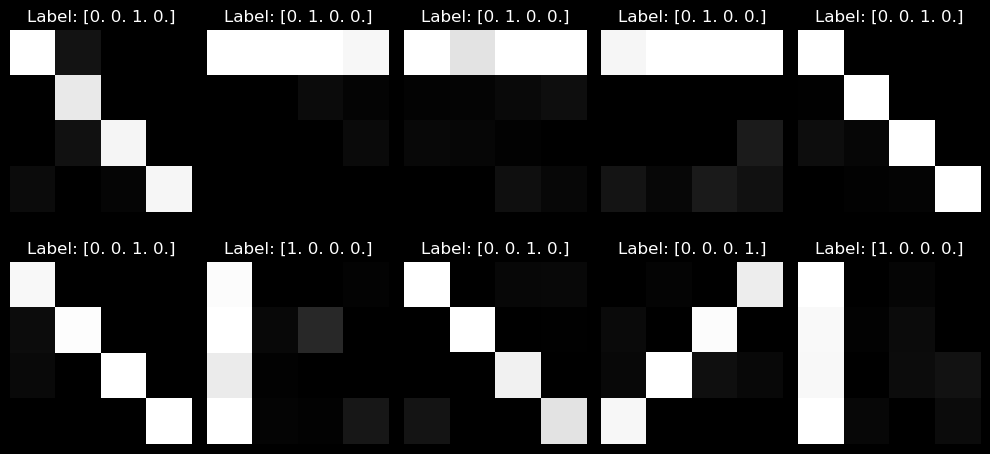

In [24]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Creating Circuit

In [ ]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
B = 4
dev = qml.device("default.qubit", wires=N * N + B)
wire_arr = nnp.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 3
STRIDE = 2

In [26]:
@qml.qnode(dev)
def qnode(inputs, 
          first_kernel, first_pooling, 
        #   second_kernel, second_pooling, 
          fc_weights, fc_bias):
    # Input Layer
    for i, j in itertools.product(range(N), range(N)):
        qml.RX(2 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    # convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    # reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    # return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]
    return [qml.probs(i) for i in reduced_wire_arr.flatten().tolist()]

In [27]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    # "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "fc_weights": (B - 1, B),
    "fc_bias": (B,),
}

qlayer = PatchedKerasLayer(qnode, weight_shapes, output_dim=(B,2))
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


({'first_kernel': (8, TensorShape([2, 2, 2])),
  'first_pooling': (4, TensorShape([2, 2])),
  'fc_weights': (12, TensorShape([3, 4])),
  'fc_bias': (4, TensorShape([4]))},
 <Quantum Keras Layer: func=qnode>)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    qlayer,
    tf.keras.layers.Lambda(prob_extraction),
])
model.load_weights('line_model.keras')

In [29]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)
model.compile(opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patched_keras_layer_1           │ (None, 4, 2)           │            28 │
│ (PatchedKerasLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[:3])  # Pass the first 5 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[:3])

Sample output shape: (3, 4)
Sample output: [[0.5994715  0.64928377 0.29282266 0.08503898]
 [0.6121711  0.7009723  0.25924528 0.06386885]
 [0.5931736  0.6607457  0.30085185 0.07383053]] [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# Model Training

In [31]:
silence_tensorflow("ERROR")
fitting = model.fit(train_images, train_labels, epochs=2, batch_size=2, validation_data=(test_images, test_labels), verbose=1, shuffle=True)

Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 408s 11s/step - accuracy: 0.3002 - loss: 1.2318 - val_accuracy: 0.4000 - val_loss: 1.2737
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 378s 11s/step - accuracy: 0.3002 - loss: 1.2301 - val_accuracy: 0.4000 - val_loss: 1.2714


In [32]:
model.get_weights()[0]

array([[[-0.95122075,  0.18691386],
        [-0.22941063,  0.8925398 ]],

       [[ 1.38084   ,  1.7801677 ],
        [ 0.30680543,  1.2669122 ]]], dtype=float32)

In [34]:
model.save("line_model.keras")